# KE5105 - Building Electrical Consumption Forecasting

# Extract, Transform and Load Data 4 - Data Imputation

## Summary of Findings

to be updated

## Load libraries

In [1]:
%matplotlib inline

import os
import myUtilities as myUtils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import random
from datetime import datetime
from pandas.tseries.offsets import MonthBegin

## Load cumulative data

In [2]:
# Load the combined building data for SDE-3.
sde3_df_list = myUtils.load_data_by_bldg(['SDE-3'], type='combined')
sde3_df_list[0][0]

'SDE-3'

In [3]:
sde3_df_list[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40460 entries, 2015-06-01 00:00:00 to 2018-07-31 23:00:00
Data columns (total 13 columns):
PWMSDE3IC1             39779 non-null float64
PWMSDE3IC2             39779 non-null float64
PWMSDE3MCC(AC)         39779 non-null float64
PWMCELCIC1             39519 non-null float64
PWMCELCIC2             39519 non-null float64
PWMSDE1                40401 non-null float64
PWMSDE2SSB             40416 non-null float64
PWMSDE2AC              40416 non-null float64
PWMSDE3Ext             40401 non-null float64
PWMStreetLight         39779 non-null float64
BTUSDE3ChillerPlant    39586 non-null float64
BTUSDE32               39586 non-null float64
BTUSDE31&2             39587 non-null float64
dtypes: float64(13)
memory usage: 4.3 MB


In [4]:
len(sde3_df_list[0][1])

In [5]:
sde3_df_list[0][1].iloc[:5, :5]

,PWMSDE3IC1,PWMSDE3IC2,PWMSDE3MCC(AC),PWMCELCIC1,PWMCELCIC2
Pt_timeStamp,,,,,
2015-06-01 00:00:00,7273387.0,6296006.0,4107576.50,NaN,NaN
2015-06-01 00:30:00,7273447.0,6296013.5,4107577.25,NaN,NaN
2015-06-01 01:00:00,7273506.0,6296020.0,4107578.00,NaN,NaN
2015-06-01 01:30:00,7273563.5,6296027.0,4107579.25,NaN,NaN
2015-06-01 02:00:00,7273622.5,6296035.5,4107580.25,NaN,NaN


In [6]:
sde3_df_list[0][1].iloc[-10:, :5]

,PWMSDE3IC1,PWMSDE3IC2,PWMSDE3MCC(AC),PWMCELCIC1,PWMCELCIC2
Pt_timeStamp,,,,,
2018-07-31 18:30:00,1108819.75,764573.38,0.0,1600592.88,726029.81
2018-07-31 19:00:00,NaN,NaN,NaN,1600595.63,726033.00
2018-07-31 19:30:00,NaN,NaN,NaN,1600595.75,726035.94
2018-07-31 20:00:00,1109030.75,764756.06,0.0,1600595.88,726038.88
2018-07-31 20:30:00,1109094.63,764805.31,0.0,1600596.00,726041.69
2018-07-31 21:00:00,1109160.88,764856.81,0.0,1600596.00,726044.31
2018-07-31 21:30:00,1109226.50,764905.56,0.0,1600596.00,726046.81
2018-07-31 22:00:00,1109290.25,764951.31,0.0,1600596.13,726049.13
2018-07-31 22:30:00,1109355.00,764992.31,0.0,1600596.25,726051.38


In [7]:
#Get the min, max month/year
start = sde3_df_list[0][1].index.min() - MonthBegin(1)  # set to first day of month
end = sde3_df_list[0][1].index.max() + MonthBegin(1)  # set to last day of month
end = end.replace(hour=0)  # set time of day to 00:00 else it is 23:00
print(start, end)

# Reindex
sde3_df_list[0][1] = myUtils.reindex_ts_df(sde3_df_list[0][1], start, end)

2015-05-01 00:00:00 2018-08-01 00:00:00


In [8]:
sde3_df_list[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57025 entries, 2015-05-01 00:00:00 to 2018-08-01 00:00:00
Freq: 30T
Data columns (total 13 columns):
PWMSDE3IC1             39778 non-null float64
PWMSDE3IC2             39778 non-null float64
PWMSDE3MCC(AC)         39778 non-null float64
PWMCELCIC1             39517 non-null float64
PWMCELCIC2             39517 non-null float64
PWMSDE1                40394 non-null float64
PWMSDE2SSB             40412 non-null float64
PWMSDE2AC              40412 non-null float64
PWMSDE3Ext             40394 non-null float64
PWMStreetLight         39778 non-null float64
BTUSDE3ChillerPlant    39585 non-null float64
BTUSDE32               39585 non-null float64
BTUSDE31&2             39586 non-null float64
dtypes: float64(13)
memory usage: 6.1 MB


In [9]:
sde3_PWM_columns = []
for i in sde3_df_list[0][1].columns:
    if 'PWM' in i:
        sde3_PWM_columns.append(i)
sde3_PWM_columns

['PWMSDE3IC1',
 'PWMSDE3IC2',
 'PWMSDE3MCC(AC)',
 'PWMCELCIC1',
 'PWMCELCIC2',
 'PWMSDE1',
 'PWMSDE2SSB',
 'PWMSDE2AC',
 'PWMSDE3Ext',
 'PWMStreetLight']

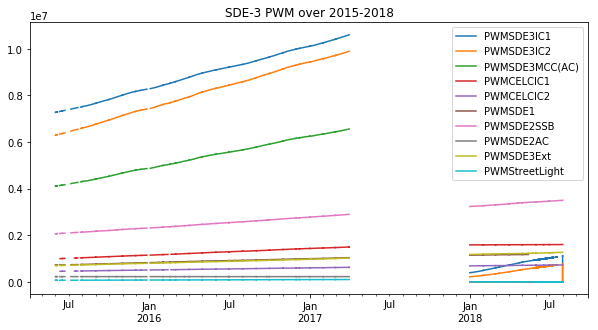

In [10]:
sde3_df_list[0][1].loc[:, sde3_PWM_columns].plot(figsize=(10, 5), title='SDE-3 PWM over 2015-2018')

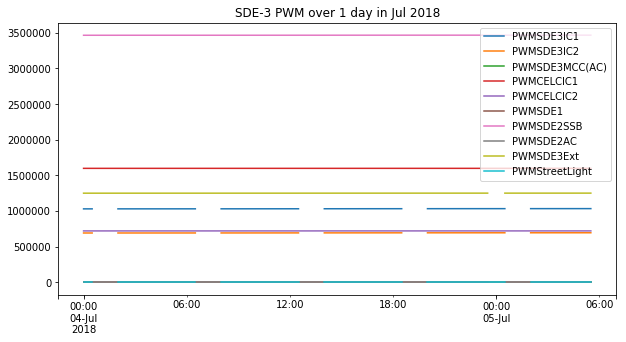

In [11]:
sde3_df_list[0][1].loc['2018-07-04 00H':'2018-07-05 05H', sde3_PWM_columns].plot(figsize=(10, 5), title='SDE-3 PWM over 1 day in Jul 2018')

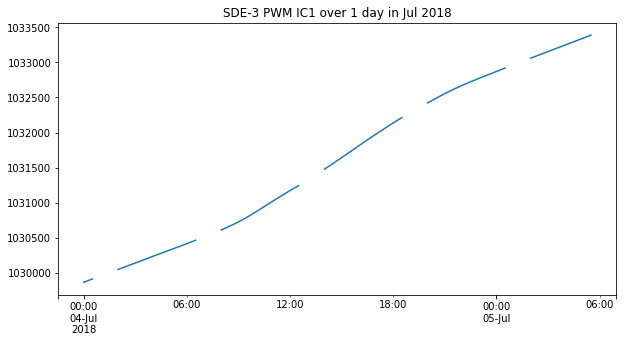

In [12]:
sde3_df_list[0][1].loc['2018-07-04 00H':'2018-07-05 05H', 'PWMSDE3IC1'].plot(figsize=(10, 5), title='SDE-3 PWM IC1 over 1 day in Jul 2018')

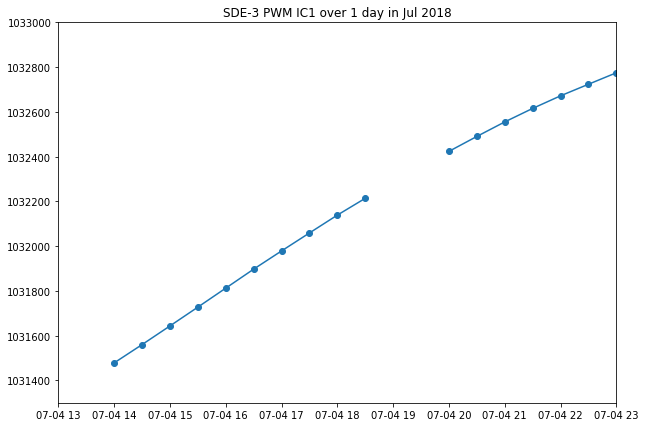

In [13]:
plt.figure(figsize=(10, 7))
plt.scatter(sde3_df_list[0][1].loc['2018-07-04 13H':'2018-07-04 23H', 'PWMSDE3IC1'].index,
            sde3_df_list[0][1].loc['2018-07-04 13H':'2018-07-04 23H', 'PWMSDE3IC1'].values)
plt.plot(sde3_df_list[0][1].loc['2018-07-04 13H':'2018-07-04 23H', 'PWMSDE3IC1'])
plt.axis(['2018-07-04 13H', '2018-07-04 23H', 1030500, 1033000])
plt.ylim((1031300, 1033000))
plt.title('SDE-3 PWM IC1 over 1 day in Jul 2018')
plt.show()

It looks like missing cumulative PWM data may be imputed with simple linear interpolation.

## Load the aggregated data

In [14]:
# Loads the aggregated PWM data for SDE-3. This csv file was created just for this data exploration.
sde3_agg_df = pd.read_csv(os.path.join('source', 'test_data', 'SDE-3.agg.csv'), index_col=0, parse_dates=True)
sde3_agg_df.iloc[:5, -5:]

,PWM-Street Light_30min_avg,BTU-SDE3-Chiller Plant_30min_avg,BTU-SDE3-2_30min_avg,BTU-SDE3 1&2_30min_avg,PWM_30min_avg
Pt_timeStamp,,,,,
2015-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN
2015-05-01 00:30:00,NaN,NaN,NaN,NaN,NaN
2015-05-01 01:00:00,NaN,NaN,NaN,NaN,NaN
2015-05-01 01:30:00,NaN,NaN,NaN,NaN,NaN
2015-05-01 02:00:00,NaN,NaN,NaN,NaN,NaN


In [15]:
sde3_agg_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57025 entries, 2015-05-01 00:00:00 to 2018-08-01 00:00:00
Data columns (total 27 columns):
PWM-SDE3 IC1                        39778 non-null float64
PWM-SDE3 IC2                        39778 non-null float64
PWM-SDE3 MCC (AC)                   39778 non-null float64
PWM-CELC IC1                        39517 non-null float64
PWM-CELC IC2                        39517 non-null float64
PWM-SDE1                            40394 non-null float64
PWM-SDE2 SSB                        40412 non-null float64
PWM-SDE2 AC                         40412 non-null float64
PWM-SDE3 Ext                        40394 non-null float64
PWM-Street Light                    39778 non-null float64
BTU-SDE3-Chiller Plant              39585 non-null float64
BTU-SDE3-2                          39585 non-null float64
BTU-SDE3 1&2                        39586 non-null float64
PWM-SDE3 IC1_30min_avg              39551 non-null float64
PWM-SDE3 IC2_30min_avg        

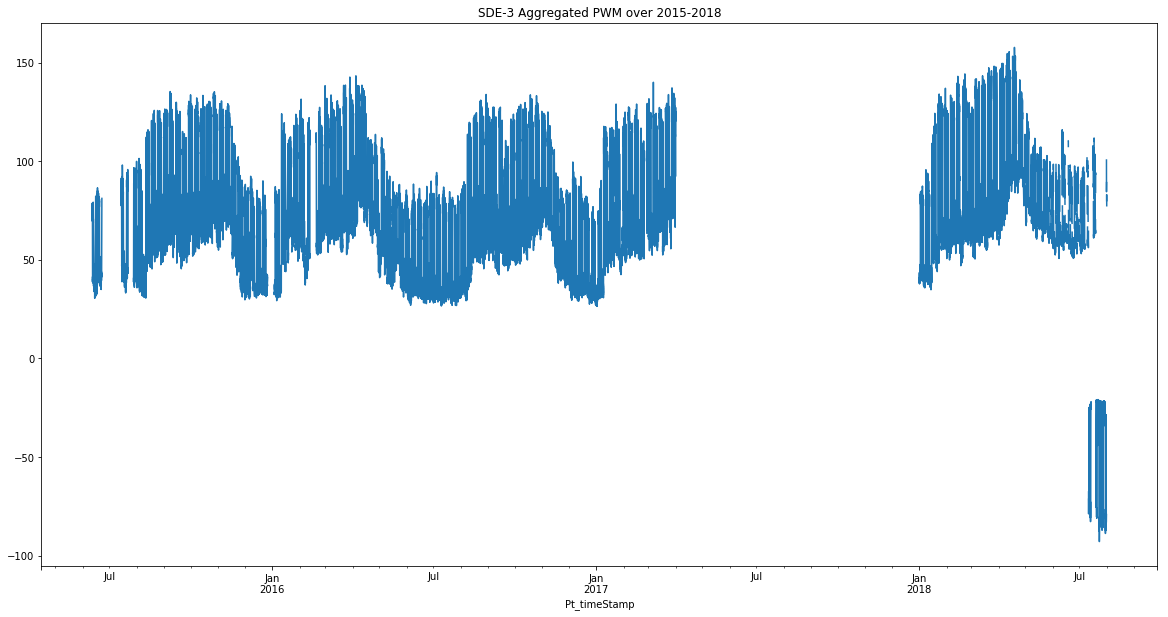

In [16]:
sde3_agg_df['PWM_30min_avg'].plot(figsize=(20, 10), title='SDE-3 Aggregated PWM over 2015-2018')

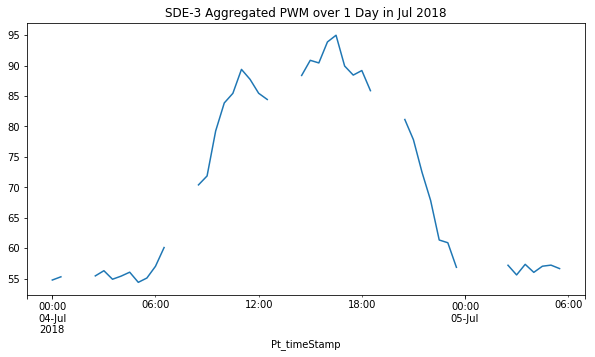

In [17]:
sde3_agg_df.loc['2018-07-04 00H':'2018-07-05 05H', 'PWM_30min_avg'].plot(figsize=(10, 5), title='SDE-3 Aggregated PWM over 1 Day in Jul 2018')

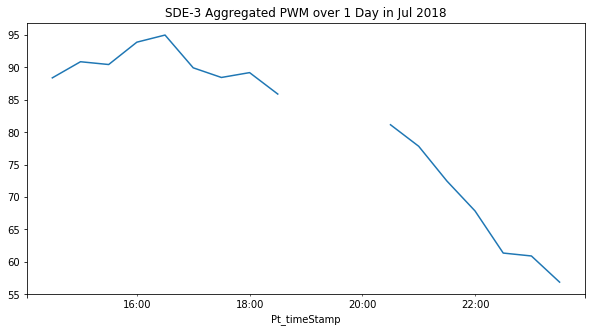

In [18]:
sde3_agg_df.loc['2018-07-04 13H':'2018-07-04 23H', 'PWM_30min_avg'].plot(figsize=(10, 5), title='SDE-3 Aggregated PWM over 1 Day in Jul 2018')

Imputation of missing aggregated PWM data is more complex in comparison with cumulative PWM data.

## Description of missing data 

In [19]:
# Generate a cumulative count of the rows with valid aggregated PWM values.
sde3_agg_df['notna cumsum'] = sde3_agg_df['PWM_30min_avg'].notna().cumsum()
sde3_agg_df.iloc[2515:2525, -6:]

,PWM-Street Light_30min_avg,BTU-SDE3-Chiller Plant_30min_avg,BTU-SDE3-2_30min_avg,BTU-SDE3 1&2_30min_avg,PWM_30min_avg,notna cumsum
Pt_timeStamp,,,,,,
2015-06-22 09:30:00,0.0,44.50,32.31,85.75,74.99,513
2015-06-22 10:00:00,0.0,123.50,32.31,85.75,73.56,514
2015-06-22 10:30:00,0.0,94.75,33.75,85.88,74.22,515
2015-06-22 11:00:00,0.0,91.00,28.63,85.75,79.43,516
2015-06-22 11:30:00,0.0,93.25,26.87,85.87,79.57,517
2015-06-22 12:00:00,0.0,79.25,27.19,57.13,81.12,518
2015-06-22 12:30:00,0.0,129.25,34.31,85.87,NaN,518
2015-06-22 13:00:00,NaN,NaN,NaN,NaN,NaN,518
2015-06-22 13:30:00,NaN,NaN,NaN,NaN,NaN,518


In [20]:
# Remove the rows with valid aggregated PWM values. We are left with sets of consecutive rows with NaN, each set of which has a unique cumulative count. 
sde3_agg_df[pd.isna(sde3_agg_df['PWM_30min_avg'])]['notna cumsum'].value_counts()[:5]

29265    13203
0         1994
518       1056
8045       369
9961       331
Name: notna cumsum, dtype: int64

In [21]:
# Convert to data frame and sort by cimulative count. We need to offset the cumulative count to get the actual starting row number of each set of consecutive NaN.
sde3_data_gaps_df = sde3_agg_df[pd.isna(sde3_agg_df['PWM_30min_avg'])]['notna cumsum'].value_counts().to_frame(name='size')
sde3_data_gaps_df.index.name = 'row'
sde3_data_gaps_df.sort_index(inplace=True)
sde3_data_gaps_df.reset_index(inplace=True)
sde3_data_gaps_df.head()

,row,size
0,0,1994
1,231,9
2,518,1056
3,686,2
4,880,296


In [22]:
# Offset the cumulative count to get the actual starting row number of each set of consecutive NaN.
sde3_data_gaps_df.loc[1:, 'row'] += sde3_data_gaps_df['size'].cumsum().values[:-1]
sde3_data_gaps_df.head()

,row,size
0,0,1994
1,2225,9
2,2521,1056
3,3745,2
4,3941,296


In [23]:
sde3_data_gaps_df['Pt_timeStamp'] = sde3_agg_df.iloc[sde3_data_gaps_df['row'].values, :].index
sde3_data_gaps_df.head(10)

,row,size,Pt_timeStamp
0,0,1994,2015-05-01 00:00:00
1,2225,9,2015-06-16 08:30:00
2,2521,1056,2015-06-22 12:30:00
3,3745,2,2015-07-18 00:30:00
4,3941,296,2015-07-22 02:30:00
5,4414,5,2015-07-31 23:00:00
6,5902,3,2015-08-31 23:00:00
7,6001,2,2015-09-03 00:30:00
8,7342,3,2015-09-30 23:00:00
9,8180,4,2015-10-18 10:00:00


In [24]:
sde3_data_gaps_df.set_index('Pt_timeStamp', inplace=True)
sde3_data_gaps_df.head()

,row,size
Pt_timeStamp,,
2015-05-01 00:00:00,0,1994
2015-06-16 08:30:00,2225,9
2015-06-22 12:30:00,2521,1056
2015-07-18 00:30:00,3745,2
2015-07-22 02:30:00,3941,296


In [25]:
sde3_data_gaps_df.describe()

,row,size
count,239.000000,239.000000
mean,48568.196653,77.167364
std,14766.483329,865.701652
min,0.000000,1.000000
25%,54008.000000,3.000000
50%,54710.000000,3.000000
75%,55448.000000,3.000000
max,57022.000000,13203.000000


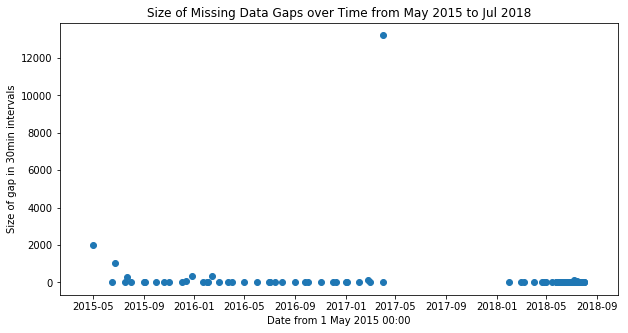

In [26]:
plt.figure(figsize=(10, 5))
plt.scatter(sde3_data_gaps_df.index, sde3_data_gaps_df['size'])
plt.title('Size of Missing Data Gaps over Time from May 2015 to Jul 2018')
plt.xlabel('Date from 1 May 2015 00:00')
plt.ylabel('Size of gap in 30min intervals')
plt.show()

The outlier (>12000 periods) is the period of total data outage from Apr 17 to Dec 17. Let's look into the period before the outage.

In [27]:
sde3_data_gaps_df[sde3_data_gaps_df['size']>10000]

,row,size
Pt_timeStamp,,
2017-03-31 23:00:00,33646,13203


This is the start of the data outage period.

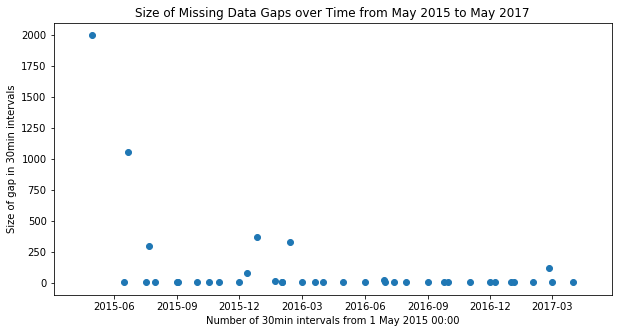

In [28]:
threshold = sde3_data_gaps_df[sde3_data_gaps_df['size']>10000].index[0] + pd.Timedelta('-30 min')
plt.figure(figsize=(10, 5))
plt.scatter([i for i in sde3_data_gaps_df.index if i <= threshold], sde3_data_gaps_df.loc[:threshold, 'size'])
plt.title('Size of Missing Data Gaps over Time from May 2015 to May 2017')
plt.xlabel('Number of 30min intervals from 1 May 2015 00:00')
plt.ylabel('Size of gap in 30min intervals')
plt.show()

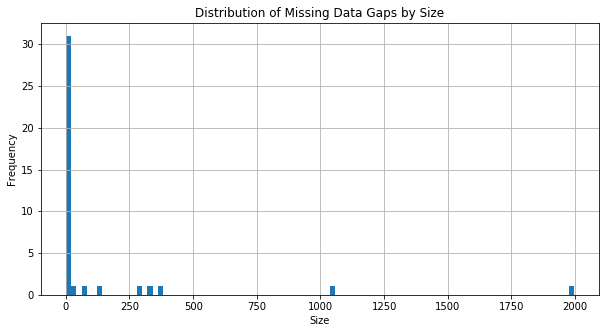

In [29]:
plt.figure(figsize=(10, 5))
sde3_data_gaps_df.loc[:threshold, 'size'].hist(bins=100)
plt.title('Distribution of Missing Data Gaps by Size')
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.show()

In [30]:
## Large gaps
sde3_data_gaps_df[sde3_data_gaps_df['size']>500]

,row,size
Pt_timeStamp,,
2015-05-01 00:00:00,0,1994
2015-06-22 12:30:00,2521,1056
2017-03-31 23:00:00,33646,13203


In [31]:
## Medium gaps
sde3_data_gaps_df[(sde3_data_gaps_df['size']>250) & (sde3_data_gaps_df['size']<500)]

,row,size
Pt_timeStamp,,
2015-07-22 02:30:00,3941,296
2015-12-26 15:30:00,11503,369
2016-02-12 15:30:00,13807,331


Large gaps are more than 20 days. Medium gaps are around 6 days.

## Impute data using ARIMA